# KATS GM-RNN

Learn how to make a forecast on the NOAA sample dataset with the pretrained GM-RNN model from Kats. 

## Step One: 
Import Dependencies

In [1]:
# !pip install influxdb-client==1.30.0
# !pip install kats

In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
from kats.consts import TimeSeriesData

from kats.models.sarima import SARIMAModel, SARIMAParams
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from kats.models.arima import ARIMAParams, ARIMAModel
from kats.models.globalmodel.ensemble import GMEnsemble, load_gmensemble_from_file

from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

In [3]:
!curl https://influx-testdata.s3.amazonaws.com/noaa.csv -o noaa.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.3M  100 10.3M    0     0  12.0M      0 --:--:-- --:--:-- --:--:-- 12.0M


### prepare data in influxdb

In [ ]:
import "experimental/csv"

relativeToNow = (tables=<-) => tables
    |> elapsed()
    |> sort(columns: ["_time"], desc: true)
    |> cumulativeSum(columns: ["elapsed"])
    |> map(fn: (r) => ({r with _time: time(v: int(v: now()) - r.elapsed * 10000000000)})) #note here there is an extra "0"

csv.from(url: "https://influx-testdata.s3.amazonaws.com/noaa.csv")
    |> relativeToNow()
    |> limit(n:1000, offset: 0)    
    |> to(bucket: "test_bucket_from_python")

## Step Two:
Instantiate the Python Client Libary and build the Flux query. 


In [5]:
client = InfluxDBClient(url="https://us-west-2-1.aws.cloud2.influxdata.com/", token="ZFSDx1udluHMpx3cshN73iZPXoCA5NXIfuHlIspzD6u33WjKdWTbgrny3rKKORebc3y5qSZdiaTOiyB-VejfQw==", org="03dd0439a8172000")
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [149]:
df = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -30d)'
  '|> filter(fn: (r) => r["_measurement"] == "average_temperature")'
  '|> filter(fn: (r) => r["_field"] == "degrees")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","degrees"])')

In [150]:
df = df.copy()
df = df.drop(columns=['result', 'table'])
df = df.rename(columns={"_time": "time"})
df

,time,degrees
0,2022-09-01 00:00:00+00:00,81.500000
1,2022-09-02 00:00:00+00:00,80.416667
2,2022-09-03 00:00:00+00:00,78.916667
3,2022-09-04 00:00:00+00:00,79.833333
4,2022-09-05 00:00:00+00:00,77.625000
5,2022-09-06 00:00:00+00:00,81.208333
6,2022-09-07 00:00:00+00:00,80.791667
7,2022-09-08 00:00:00+00:00,79.416667
8,2022-09-09 00:00:00+00:00,80.250000
9,2022-09-10 00:00:00+00:00,79.083333


In [151]:
df_plot = df.set_index('time')

<AxesSubplot:xlabel='time'>

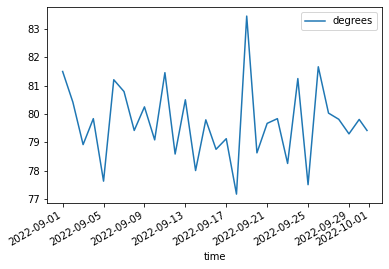

In [152]:
df_plot.plot()

## Step Three: 
Reformat timestamp.

In [153]:
df["time"] = df["time"].apply(lambda x: x.strftime('%Y-%m-%d'))
df = df.head(15)
df.head(12)

,time,degrees
0,2022-09-01,81.500000
1,2022-09-02,80.416667
2,2022-09-03,78.916667
3,2022-09-04,79.833333
4,2022-09-05,77.625000
5,2022-09-06,81.208333
6,2022-09-07,80.791667
7,2022-09-08,79.416667
8,2022-09-09,80.250000
9,2022-09-10,79.083333


# Step Four: 
Split into train and test

In [154]:
train = df.head(12)
test = df.tail(3).reset_index(drop=True)

In [155]:
train.head(12)

,time,degrees
0,2022-09-01,81.500000
1,2022-09-02,80.416667
2,2022-09-03,78.916667
3,2022-09-04,79.833333
4,2022-09-05,77.625000
5,2022-09-06,81.208333
6,2022-09-07,80.791667
7,2022-09-08,79.416667
8,2022-09-09,80.250000
9,2022-09-10,79.083333


In [156]:
test.head(3)

,time,degrees
0,2022-09-13,80.500000
1,2022-09-14,78.000000
2,2022-09-15,79.791667


In [157]:
df_ts = TimeSeriesData(train)

In [158]:
df_ts

,time,degrees
0,2022-09-01,81.500000
1,2022-09-02,80.416667
2,2022-09-03,78.916667
3,2022-09-04,79.833333
4,2022-09-05,77.625000
5,2022-09-06,81.208333
6,2022-09-07,80.791667
7,2022-09-08,79.416667
8,2022-09-09,80.250000
9,2022-09-10,79.083333


## Step Five:
Load model and create forecast. 

In [159]:
gme_rnn = load_gmensemble_from_file("models/pretrained_daily_rnn.p")
gme_rnn

In [177]:
fcsts = gme_rnn.predict(df_ts, steps = 3)
fcsts

{0:    fcst_quantile_0.5  fcst_quantile_0.01  fcst_quantile_0.05  \
 0          82.338249           79.717224           80.777687   
 1          82.017944           78.254982           79.705215   
 2          82.624687           78.016602           79.776276   
 
    fcst_quantile_0.95  fcst_quantile_0.99       time  
 0           83.747787           84.841911 2022-09-13  
 1           84.020134           85.198349 2022-09-14  
 2           84.994812           86.624702 2022-09-15  }

In [161]:
fcsts_df = list(fcsts.items())[0][1]
fcsts_df

,fcst_quantile_0.5,fcst_quantile_0.01,fcst_quantile_0.05,fcst_quantile_0.95,fcst_quantile_0.99,time
0,82.338249,79.717224,80.777687,83.747787,84.841911,2022-09-13
1,82.017944,78.254982,79.705215,84.020134,85.198349,2022-09-14
2,82.624687,78.016602,79.776276,84.994812,86.624702,2022-09-15


In [184]:
fcsts_df = fcsts_df.join(test["degrees"])
fcsts_df.head()

,fcst_quantile_0.5,time,location,degrees
0,82.338249,2022-09-13,coyote_creek,80.500000
1,82.017944,2022-09-14,coyote_creek,78.000000
2,82.624687,2022-09-15,coyote_creek,79.791667


<AxesSubplot:xlabel='time'>

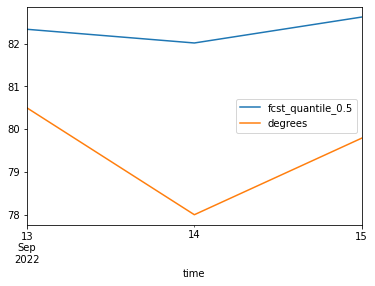

In [180]:
fcsts_df_plot = fcsts_df.set_index('time')
fcsts_df_plot.plot()

In [185]:
fcsts_df = fcsts_df[['fcst_quantile_0.5', 'degrees', 'time']]
fcsts_df['location'] = "coyote_creek"
fcsts_df

,fcst_quantile_0.5,degrees,time,location
0,82.338249,80.500000,2022-09-13,coyote_creek
1,82.017944,78.000000,2022-09-14,coyote_creek
2,82.624687,79.791667,2022-09-15,coyote_creek


## Step Six:
Write data with the client library. 

In [190]:
write_api.write(bucket="test_bucket_from_python",
               record=fcsts_df,
               data_frame_measurement_name="forecast",
               data_frame_tag_columns=["location"],
               data_frame_timestamp_column="time")

In [191]:
dff = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -30d)'
  '|> filter(fn: (r) => r["_measurement"] == "forecast")'
  '|> filter(fn: (r) => r["_field"] == "fcst_quantile_0.5")'                              
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","fcst_quantile_0.5"])')
dff = dff.copy()
dff = dff.drop(columns=['result', 'table'])
dff = dff.rename(columns={"_time": "time"})
dff.head()

,time,fcst_quantile_0.5
0,2022-09-14 00:00:00+00:00,82.338249
1,2022-09-15 00:00:00+00:00,82.017944
2,2022-09-16 00:00:00+00:00,82.624687
3,2022-09-17 00:00:00+00:00,77.824249
4,2022-09-18 00:00:00+00:00,76.986336


In [167]:
dfm = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -30d)'
  '|> filter(fn: (r) => r["_measurement"] == "average_temperature")'
  '|> filter(fn: (r) => r["_field"] == "degrees")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","degrees"])')
dfm = dfm.copy()
dfm = dfm.drop(columns=['result', 'table'])
dfm = dfm.rename(columns={"_time": "time"})
dfm.head()

,time,degrees
0,2022-09-01 00:00:00+00:00,81.500000
1,2022-09-02 00:00:00+00:00,80.416667
2,2022-09-03 00:00:00+00:00,78.916667
3,2022-09-04 00:00:00+00:00,79.833333
4,2022-09-05 00:00:00+00:00,77.625000


In [174]:
df = pd.concat([dff, dfm], axis=1, join="inner")
df

,time,fcst_quantile_0.5,time,degrees
0,2022-09-14 00:00:00+00:00,82.338249,2022-09-01 00:00:00+00:00,81.500000
1,2022-09-15 00:00:00+00:00,82.017944,2022-09-02 00:00:00+00:00,80.416667
2,2022-09-16 00:00:00+00:00,82.624687,2022-09-03 00:00:00+00:00,78.916667
3,2022-09-29 00:00:00+00:00,80.704765,2022-09-04 00:00:00+00:00,79.833333
4,2022-09-30 00:00:00+00:00,81.536484,2022-09-05 00:00:00+00:00,77.625000
5,2022-09-30 18:33:30.812452+00:00,80.623299,2022-09-06 00:00:00+00:00,81.208333


<AxesSubplot:xlabel='time'>

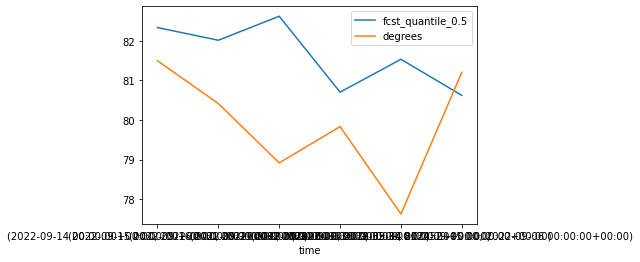

In [175]:
df_plot = df.set_index('time')
df_plot.plot()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
### Write dataframe to bucket with data_frame_tag_columns=["location"]

In [111]:
data = {'temperature': [10, 11, 12], 
         'time': pd.to_datetime(["2022-09-25", "2022-09-26", "2022-09-27"]), 
         'location': ["coyote_creek", "coyote_creek", "coyote_creek"]}

In [112]:
df=pd.DataFrame(data)
df

,temperature,time,location
0,10,2022-09-25,coyote_creek
1,11,2022-09-26,coyote_creek
2,12,2022-09-27,coyote_creek


In [113]:
write_api.write(bucket="test_bucket_from_python",
               record=df,
               data_frame_measurement_name="test",
               data_frame_tag_columns=["location"],
               data_frame_timestamp_column="time")

In [114]:
df = query_api.query_data_frame('from(bucket: "test_bucket_from_python")'
  '|> range(start: -6d)'
  '|> filter(fn: (r) => r["_measurement"] == "test")'
  '|> filter(fn: (r) => r["_field"] == "temperature")'
  '|> filter(fn: (r) => r["location"] == "coyote_creek")'
  '|> aggregateWindow(every: 1d, fn: mean, createEmpty: false)'
  '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")'
  '|> keep(columns:["_time","temperature", "location"])')
df = df.copy()
df = df.drop(columns=['result', 'table'])
df = df.rename(columns={"_time": "time"})
df.head()

,time,location,temperature
0,2022-09-26 00:00:00+00:00,coyote_creek,10.0
1,2022-09-27 00:00:00+00:00,coyote_creek,11.0
2,2022-09-28 00:00:00+00:00,coyote_creek,12.0
3,2022-09-29 00:00:00+00:00,coyote_creek,10.0
4,2022-09-30 00:00:00+00:00,coyote_creek,11.0
